# Deduplication Problem by Content Square

## Problem statement
Movies are collected from different data providers. Data providers don't always use the same information to describe the same movie.
Given a list of movies where each movie is described by two different providers, the task is to identify the duplications.

The purpose of this kernel is first to explore the dataset, then, try to identify duplicated records.

## What is duplication?
In our case, duplicate means we can have two slightly different entries for the same movie. This is what is called in academic studies __record linkage__.
To solve our problem, we will use the probabilistic approch.

## Reminder
For two entries describing the same movie, it's possible to have the following differences:
* id: each is unique
* year: ±1 year at maximum
* length: ±5% more, 2* |x-y| / (x+y) <= 0.05 where x and y is the provided movie length
* \[genre, actors, directors\]: different order, or missing one or many -> no words shuffle

## Setup Python

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))

print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Seaborn: {sns.__version__}")

Pandas: 1.2.4
Numpy: 1.20.1
Seaborn: 0.11.1


<Figure size 1152x432 with 0 Axes>

## Read the dataset

In [61]:
df = pd.read_csv('movies.tsv', sep='\t', low_memory=False) # low_memory avoid reading by chunks and mixed types issues
df = df.replace(r'\N', np.NaN) # Unknown fields are marked \N
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558458 entries, 0 to 558457
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         558458 non-null  object
 1   year       558458 non-null  int64 
 2   length     558458 non-null  int64 
 3   genre      483540 non-null  object
 4   directors  461089 non-null  object
 5   actors     415669 non-null  object
dtypes: int64(2), object(4)
memory usage: 25.6+ MB


In [62]:
df.head()

,id,year,length,genre,directors,actors
0,9bd4cbab-0af9-43c1-a6fe-8440b5f7979a,2015,62,NaN,Stephen Ang,"Stephen Ang,George Capacete,Kimberly Cashner,P..."
1,7e0a9d8e-99b7-4a88-b610-3a52faaae2c1,1929,64,"Crime,Drama,Mystery",Phil Rosen,"Ricardo Cortez,Nancy Welford"
2,6acef12b-404c-4a8f-b365-cef798585893,1993,87,Thriller,Christian González,"Leonardo Daniel,Roberto 'Flaco' Guzmán,Armando..."
3,9e41e9a6-5628-4123-9353-b9487654ed84,2011,46,"Biography,Documentary,Drama",Han Tang,NaN
4,8b2789fe-36fc-4f74-9094-b11ec46bfd42,2018,60,Documentary,NaN,NaN


In [63]:
df.describe()

,year,length
count,558458.000000,558458.000000
mean,1992.097026,87.525569
std,25.832787,53.825148
min,1893.000000,1.000000
25%,1976.000000,73.000000
50%,2004.000000,88.000000
75%,2013.000000,99.000000
max,2026.000000,14400.000000


Out of 558 458 entries, only genre, directors and actors contains null values and need to be processed.

Year and length does not look bad, 75% percentile make total sense. If my assumption is true about {genre, directorsn, actors}, overall the data do not look noisy.

## Data cleaning

In [64]:
def split_list(x):
    return x if isinstance(x, float) else set([x.strip() for x in x.split(',')])

df['actors'] = df['actors'].apply(split_list)
df['genre'] = df['genre'].apply(split_list)
df['directors'] = df['directors'].apply(split_list)

df.head()

,id,year,length,genre,directors,actors
0,9bd4cbab-0af9-43c1-a6fe-8440b5f7979a,2015,62,NaN,{Stephen Ang},"{Stephen Ang, Kimberly Cashner, Peggy Glenn, G..."
1,7e0a9d8e-99b7-4a88-b610-3a52faaae2c1,1929,64,"{Mystery, Crime, Drama}",{Phil Rosen},"{Ricardo Cortez, Nancy Welford}"
2,6acef12b-404c-4a8f-b365-cef798585893,1993,87,{Thriller},{Christian González},"{Leonardo Daniel, Roberto 'Flaco' Guzmán, Arma..."
3,9e41e9a6-5628-4123-9353-b9487654ed84,2011,46,"{Documentary, Biography, Drama}",{Han Tang},NaN
4,8b2789fe-36fc-4f74-9094-b11ec46bfd42,2018,60,{Documentary},NaN,NaN


## Visualization

It is time to visualize the repartition of null values accross our dataset:

<AxesSubplot:>

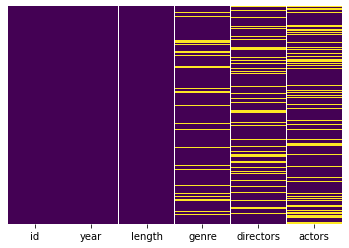

In [65]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [66]:
null_actors = df[df['actors'].isna()]
null_actors_percentage = len(null_actors)*100/len(df['actors'])

null_directors = df[df['directors'].isna()]
null_directors_percentage = len(null_directors)*100/len(df['directors'])

null_genre = df[df['genre'].isna()]
null_genre_percentage = len(null_genre)*100/len(df['genre'])

print("NaN actors values: {} ({:.2f}%)".format(len(null_actors), null_actors_percentage))
print("NaN directors values: {} ({:.2f}%)".format(len(null_directors), null_directors_percentage))
print("NaN actors values: {} ({:.2f}%)".format(len(null_genre), null_genre_percentage))

NaN actors values: 142789 (25.57%)
NaN directors values: 97369 (17.44%)
NaN actors values: 74918 (13.42%)


### Year
How is the repartition?

<AxesSubplot:xlabel='year'>

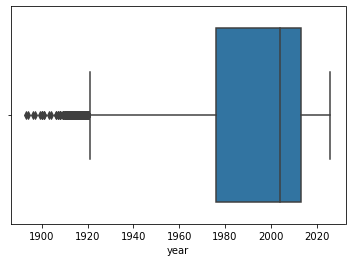

In [67]:
sns.boxplot(data=df, x='year')

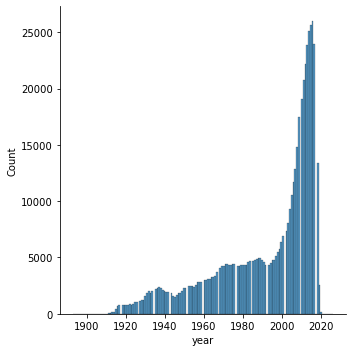

In [68]:
sns.displot(data=df, x='year')

In [69]:
df['year'].nunique()

129

Year has 129 unique values, not evenly partitioned. Using year as blocking key is probably not a good idea because that will generate huge blocks and will not split enough the space area.

### Length

<AxesSubplot:xlabel='length'>

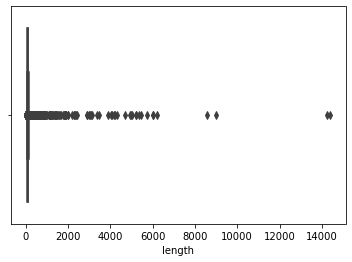

In [70]:
sns.boxplot(data=df, x='length')

In [71]:
df['length'].nunique()

563

Same.

### Genre
Analyze genre occurences for columns in list format.

In [72]:
from collections import defaultdict

def count_list_values(serie):
    d = defaultdict(int)
    for e in serie:
        if not isinstance(e, float):
            for v in e:
                d[v] += 1
            
    return dict(d)

genres_occ = count_list_values(df['genre'])
print(f'Number of genre: {len(genres_occ.keys())}')

Number of genre: 28


<AxesSubplot:>

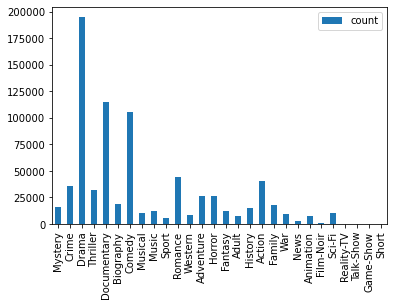

In [73]:
genres = pd.DataFrame.from_dict(genres_occ, orient='index', columns=['count'])
genres.plot(kind='bar')

Let be honest, drama is the best kind of movie and the data show it.

### Directors

In [75]:
directors_occ = count_list_values(df['directors'])
directors = pd.DataFrame.from_dict(directors_occ, orient='index', columns=['count'])

print(f'Number of directors: {len(directors_occ.keys())}')

Number of directors: 130533


In [76]:
for i in range(1, 6):
    n_movies = len(df[df['directors'].apply(lambda x: 0 if isinstance(x, float) else len(x)) == i])
    print(f"Number of movie with {i} directors: {n_movies}")

Number of movie with 1 directors: 420927
Number of movie with 2 directors: 34100
Number of movie with 3 directors: 3709
Number of movie with 4 directors: 912
Number of movie with 5 directors: 428


A large majority of movie only has one director apparently. It's a cheap and effective blocking. 

## Solution
We want to avoid comparing all records against eachother, that would require N*(N-1)/2. For our use case, that represent more than 15B comparisons, any sane person knows that a quadratric algorithm is not suitable. We need to cut the search space first, and we have a lot way to do that:
* Standard blocking
* Suffix Arrays Blocking
* Q-Grams Blocking
* Token Blocking

I embrace the KISS principle, so I'll stick with standard blocking.

### Indexing / Blocking 

In [79]:
import recordlinkage as rl

def _hash(x):
    return x if not isinstance(x, set) else ','.join(x)

df = df.assign(blocking_key=lambda x: x.directors.apply(_hash))    
df.head()

,id,year,length,genre,directors,actors,blocking_key
0,9bd4cbab-0af9-43c1-a6fe-8440b5f7979a,2015,62,NaN,{Stephen Ang},"{Stephen Ang, Kimberly Cashner, Peggy Glenn, G...",Stephen Ang
1,7e0a9d8e-99b7-4a88-b610-3a52faaae2c1,1929,64,"{Mystery, Crime, Drama}",{Phil Rosen},"{Ricardo Cortez, Nancy Welford}",Phil Rosen
2,6acef12b-404c-4a8f-b365-cef798585893,1993,87,{Thriller},{Christian González},"{Leonardo Daniel, Roberto 'Flaco' Guzmán, Arma...",Christian González
3,9e41e9a6-5628-4123-9353-b9487654ed84,2011,46,"{Documentary, Biography, Drama}",{Han Tang},NaN,Han Tang
4,8b2789fe-36fc-4f74-9094-b11ec46bfd42,2018,60,{Documentary},NaN,NaN,NaN


In [80]:
indexer = rl.BlockIndex('blocking_key')
pairs = indexer.index(df)

print(f"Full index: {len(df)} records, {len(pairs)} pairs")

Full index: 558458 records, 3923169 pairs


In [81]:
pairs.to_frame()[:10].values

array([[390336,      0],
       [517912,      0],
       [517912, 390336],
       [  5881,      1],
       [  6528,      1],
       [  6528,   5881],
       [ 10009,      1],
       [ 10009,   5881],
       [ 10009,   6528],
       [ 11448,      1]], dtype=int64)

In [82]:
pairs.to_frame().head()

0       1
390336 0       390336       0
517912 0       517912       0
       390336  517912  390336
5881   1         5881       1
6528   1         6528       1

In [83]:
df.iloc[517912]

id                           f0b43346-24f2-477b-9e0b-0c41e62ac7e3
year                                                         2016
length                                                         60
genre                                                         NaN
directors                                           {Stephen Ang}
actors          {Stephen Ang, Kimberly Cashner, Peggy Glenn, G...
blocking_key                                          Stephen Ang
Name: 517912, dtype: object

In [84]:
df.iloc[0]

id                           9bd4cbab-0af9-43c1-a6fe-8440b5f7979a
year                                                         2015
length                                                         62
genre                                                         NaN
directors                                           {Stephen Ang}
actors          {Stephen Ang, Kimberly Cashner, Peggy Glenn, G...
blocking_key                                          Stephen Ang
Name: 0, dtype: object

In [85]:
df.iloc[390336]

id              365136a9-3218-4cac-b248-74dbaaf8800c
year                                            2015
length                                            59
genre                                       {Horror}
directors                              {Stephen Ang}
actors                              {Earle MacVeigh}
blocking_key                             Stephen Ang
Name: 390336, dtype: object

### Similarity function
Jaccard similarity looks like a good candidate to rate the similarity between two set of {genre, directors, actors} because we can assume only the order or the number of values are different.

In [86]:
vectorized_expr = np.vectorize(lambda x, y: 1.0 if 2*abs(x-y)/(x+y) <= 0.05 else 0.0)
jaccard_vec = np.vectorize(lambda x, y: 0.0 if (isinstance(x, float) or isinstance(y, float)) else float(len(x.intersection(y)) / len(x.union(y))))

def length_similarity(s1, s2):
    return vectorized_expr(s1, s2)

def jaccard_similarity(s1, s2):
    return jaccard_vec(s1, s2)

comp = rl.Compare()
comp.numeric('year', 'year', method='step', offset=1, label='year') # Step: expr = 'abs(d - origin) <= offset'
comp.compare_vectorized(length_similarity, 'length', 'length', label='length')
comp.compare_vectorized(jaccard_similarity, 'genre', 'genre', label='genre')
comp.compare_vectorized(jaccard_similarity, 'directors', 'directors', label='directors')
comp.compare_vectorized(jaccard_similarity, 'actors', 'actors', label='actors')

comparison_vectors = comp.compute(pairs, df)
comparison_vectors.head()

year  length     genre  directors  actors
390336 0        1.0     1.0  0.000000        1.0     0.0
517912 0        1.0     1.0  0.000000        1.0     1.0
       390336   1.0     1.0  0.000000        1.0     0.0
5881   1        0.0     0.0  0.333333        1.0     0.0
6528   1        0.0     1.0  0.000000        1.0     0.0

In [99]:
scores = np.average(comparison_vectors.values, axis=1, weights=[30, 30, 10, 15, 15])
scores_comparison_vectors = comparison_vectors.assign(score=scores)
scores_comparison_vectors.head()

year  length     genre  directors  actors     score
390336 0        1.0     1.0  0.000000        1.0     0.0  0.750000
517912 0        1.0     1.0  0.000000        1.0     1.0  0.900000
       390336   1.0     1.0  0.000000        1.0     0.0  0.750000
5881   1        0.0     0.0  0.333333        1.0     0.0  0.183333
6528   1        0.0     1.0  0.000000        1.0     0.0  0.450000

In [115]:
matches = comparison_vectors[scores_comparison_vectors['score'] >= 0.85]
matches.head()

,,year,length,genre,directors,actors
517912,0,1.0,1.0,0.0,1.0,1.000
14718,11448,1.0,1.0,1.0,1.0,0.000
25985,11448,1.0,1.0,1.0,1.0,0.000
68823,51513,1.0,1.0,1.0,1.0,0.500
74353,11448,1.0,1.0,1.0,1.0,0.125


In [116]:
matches.shape

(188031, 5)

**Reminder**: The algorithm is generic and match more than one single value.

In [11]:
display(df.loc[[517912]])
print("matched:")
display(df.loc[matches.loc[(517912,)].index])

,id,year,length,genre,directors,actors
517912,f0b43346-24f2-477b-9e0b-0c41e62ac7e3,2016,60,NaN,Stephen Ang,"Stephen Ang,George Capacete,Kimberly Cashner,P..."


matched:


<ipython-input-11-b07b460e1dc8>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  display(df.loc[matches.loc[(517912,)].index])


,id,year,length,genre,directors,actors
0,9bd4cbab-0af9-43c1-a6fe-8440b5f7979a,2015,62,NaN,Stephen Ang,"Stephen Ang,George Capacete,Kimberly Cashner,P..."


In [124]:
with open('result.tsv', 'w') as f:
    for index, row in matches.iterrows():
        f.write(f"{df.iloc[index[0]]['id']}\t {df.iloc[index[1]]['id']}\n")